In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tqdm
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/temur/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
n_hands, n_dealer_cards, n_usable_ace = 32, 11, 2
nS, nA = n_hands * n_dealer_cards * n_usable_ace, 2
final_states = np.where([hand > 20 for hand in range(n_hands) 
                         for dealer in range(n_dealer_cards) for ace in range(n_usable_ace)])[0]

def get_state(hand, dealer, usable_ace):
    return hand * n_dealer_cards * n_usable_ace + dealer * n_usable_ace + int(usable_ace)

def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    # при операции stick, игра заканчивается
    Q[:, 0] = 0.0
    return Q

In [3]:
def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax( Q, axis=1 )

def run_episode_actions(env, pi, eps=0.0):
    s = get_state(*(env.reset()))
    next_action = pi[s] if np.random.rand() > eps else np.random.randint(nA)
    states, actions, rewards = [s], [next_action], [0]
    while True:
        observation, reward, done, info = env.step(next_action)
        s = get_state(*observation)
        states.append(s)
        next_action = pi[s] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards

def update_returns_actions(R, states, actions, rewards, gamma=1.0):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    g = 0
    if state_first_visit[states[-1]] == len(states)-1:
        mean_r, cnt = R[states[-1]][actions[-1]]
        R[states[-1]][actions[-1]] = ((mean_r * cnt + g) / (cnt + 1), cnt + 1)
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[states[t]] == t:
            mean_r, cnt = R[states[t]][actions[t]]
            R[states[t]][actions[t]] = ((mean_r * cnt + g) / (cnt + 1), cnt + 1)
    return R

def get_Q_by_R(R, Q_default=None):
    Q = Q_default if Q_default is not None else np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            if R[s][a][1] > 0:
                Q[s][a] = R[s][a][0]
    return Q

In [4]:
def conduct_experiments_pi(env, pi, num_experiments=1000):
    total_reward = []
    for _ in range(num_experiments):
        s = get_state(*(env.reset()))
        total_reward.append(0)
        while True:
            observation, reward, done, info = env.step(pi[s])
            s = get_state(*observation)
            total_reward[-1] += reward
            if done:
                break
    env.close()
    return np.mean(total_reward)

## Часть первая, с блекджеком и стратегиями

Простая стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

In [36]:
env = gym.make('Blackjack-v0', natural=True)

pi = np.array([int(hand <= 18) for hand in range(n_hands) 
                         for dealer in range(n_dealer_cards) for ace in range(n_usable_ace)])

num_experiments_pi = 100000
reward = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
print('Средний выигрыш с простой стратегией:', reward)

env.close()

Средний выигрыш с простой стратегией: -0.18387


### Monte-Carlo control с on-policy исследованием

In [37]:
env = gym.make('Blackjack-v0', natural=True)
init_episodes, total_episodes = 100, 500000
num_experiments_pi = 500000
step_experiments_pi = total_episodes // 10
gammas = [0.7, 0.8, 0.9, 1.0]
test_results = [[] for _ in gammas]

for j, gamma in enumerate(gammas):
    print(f"Gamma={gamma}", flush=True)
    R = [ [ (0, 0) for _ in range(nA) ] for _ in range(nS) ]

    Q = get_random_Q(env)
    pi = compute_policy_by_Q(env, Q)

    for _ in tqdm.tqdm(range(init_episodes)):
        states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)

    for i in tqdm.tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)
        Q = get_Q_by_R(R, Q_default=Q)
        pi = compute_policy_by_Q(env, Q)
        if (i+1) % step_experiments_pi == 0 or i == total_episodes - 1:
            reward = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
            test_results[j].append((i, reward))
        
env.close()

Gamma=0.7


100%|██████████| 500000/500000 [08:36<00:00, 967.27it/s]   

Gamma=0.8



100%|██████████| 500000/500000 [08:40<00:00, 960.97it/s]  

Gamma=0.9



100%|██████████| 500000/500000 [08:29<00:00, 980.53it/s]   

Gamma=1.0



100%|██████████| 500000/500000 [08:51<00:00, 941.18it/s]  


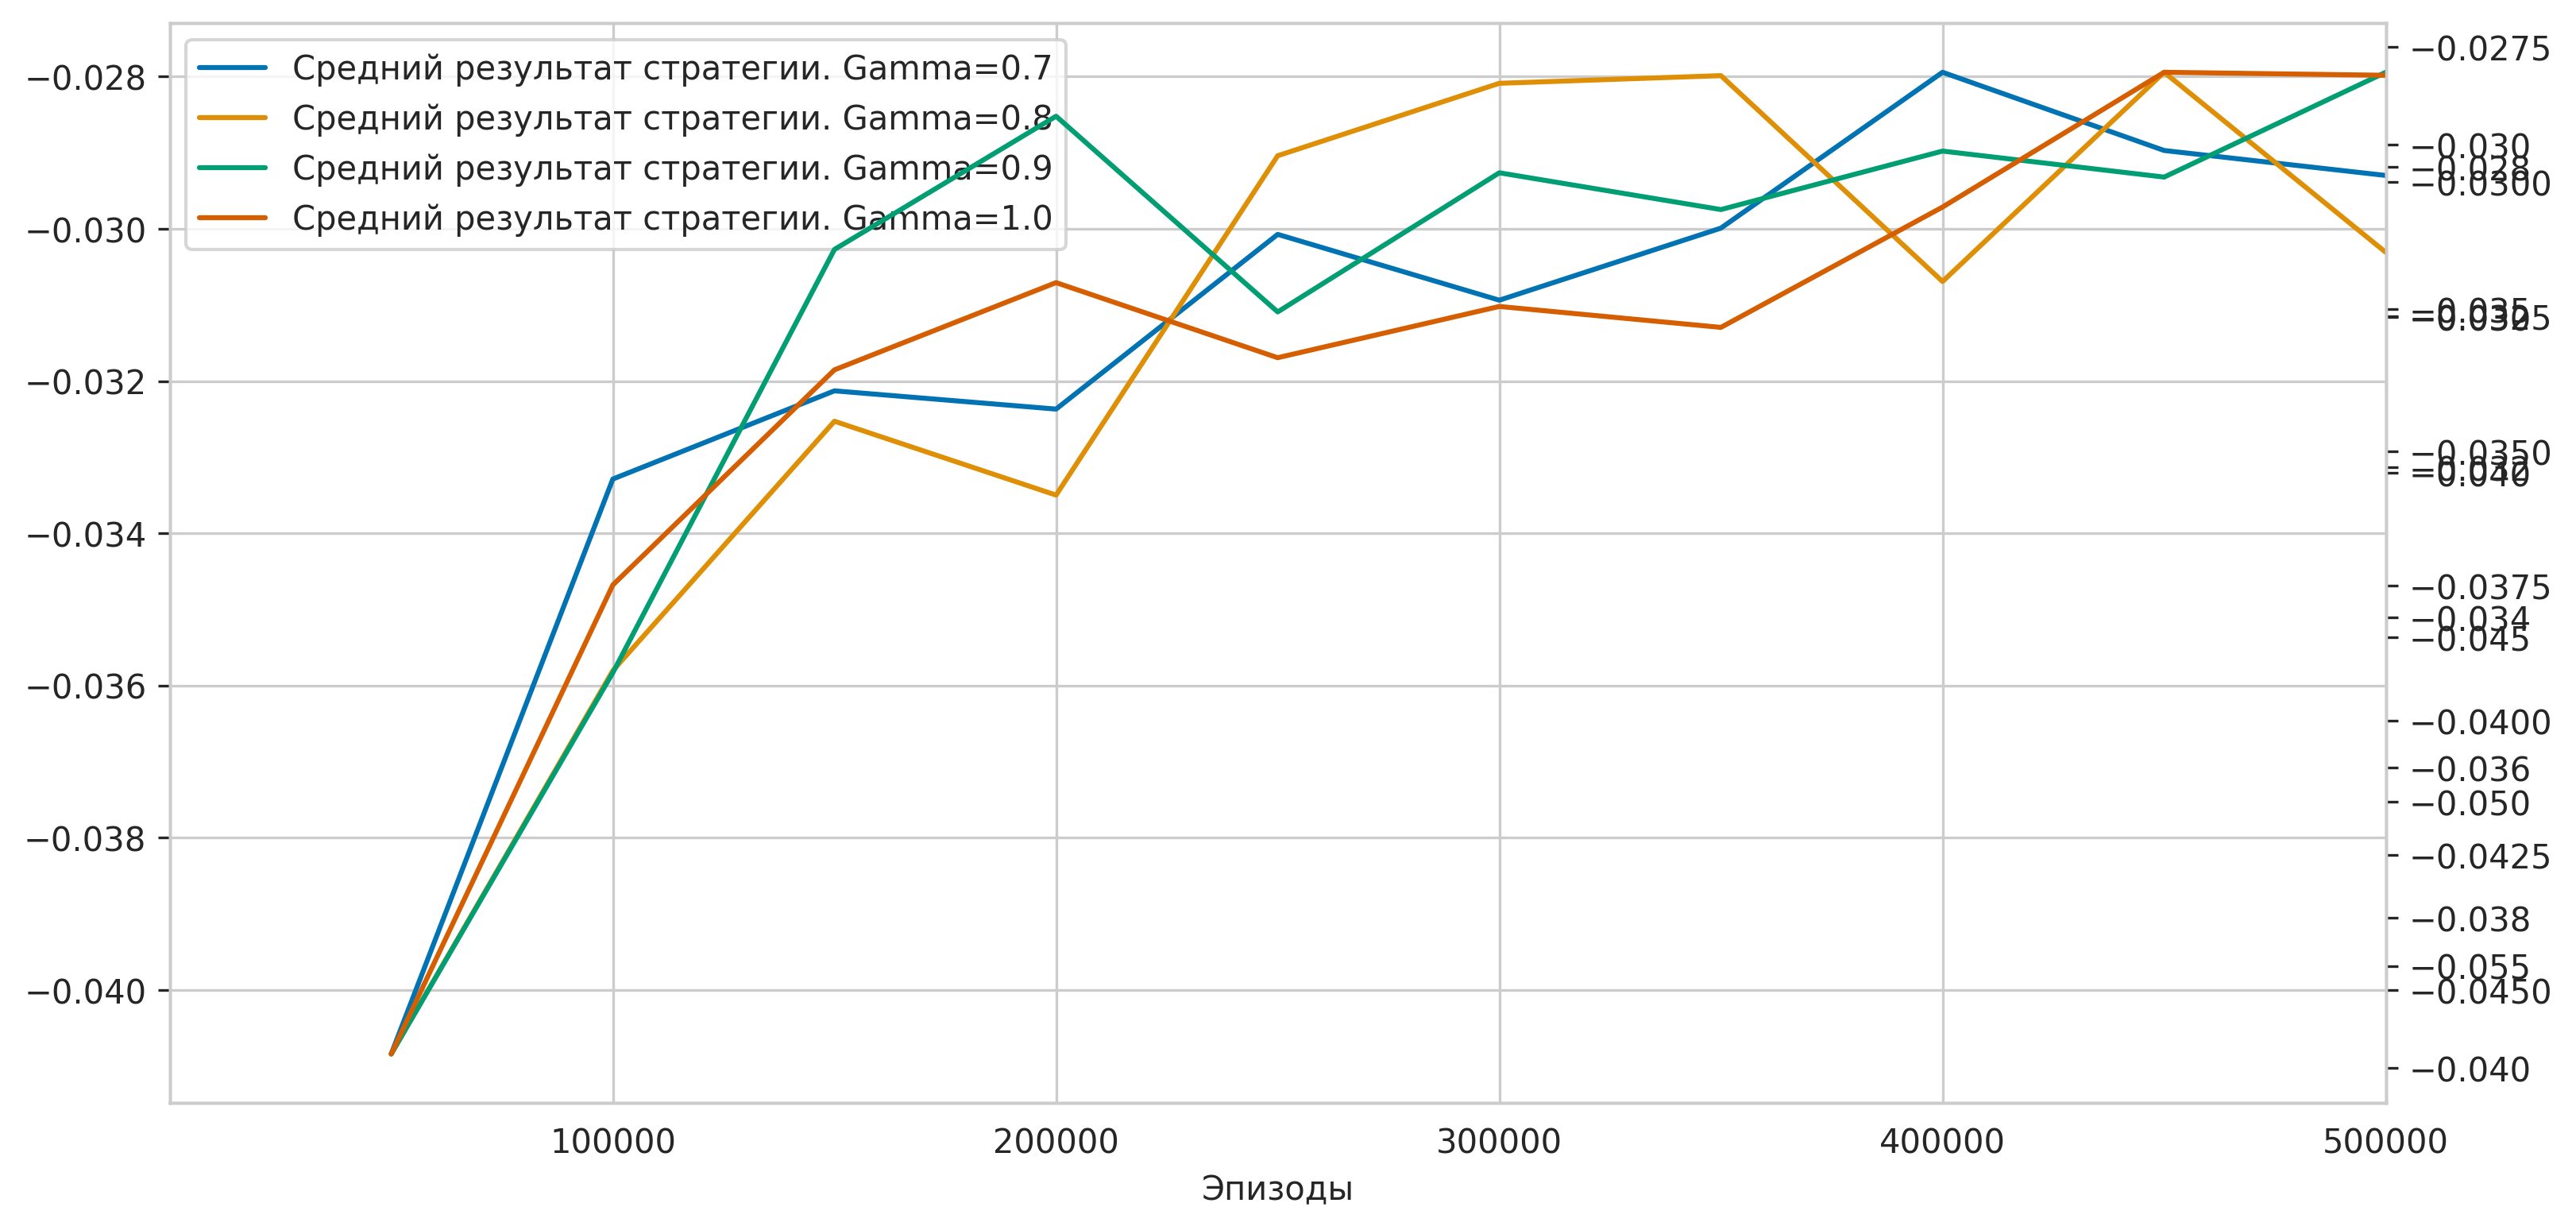

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

lines = []
labels = []
for i in range(len(gammas)):
    if i == 0:
        ax2 = ax
    else:
        ax2 = ax.twinx()
        ax2.grid(None)
    x, y = [res[0] for res in test_results[i]], [res[1] for res in test_results[i]]
    line = ax2.plot(x, y, label=f"Средний результат стратегии. Gamma={gammas[i]}", color=f"C{i}")
    lines += line
    labels += [l.get_label() for l in line]
ax.legend(lines, labels, loc=0)
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды");

В целом большое разницы между разными стратегиями не наблюдается. Но в дальшейших экспериментах использовалось значение gamma=0.9.

## Часть вторая, удвоенная

В blackjack_v2.py реализована версия игры с удвоением. В action добавлена еще одна опция.

In [40]:
from blackjack_v2 import BlackjackEnv2

In [41]:
nA = 3

def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    Q[:, 0] = 0.0
    # при удвоении игра также заканчивается
    Q[:, 2] = 0.0
    return Q

In [42]:
env = BlackjackEnv2(natural=True)
init_episodes, total_episodes = 100, 500000
num_experiments_pi = 500000
step_experiments_pi = total_episodes // 10
gammas = [0.9]
test_results2 = [[] for _ in gammas]

for j, gamma in enumerate(gammas):
    print(f"Gamma={gamma}", flush=True)
    R = [ [ (0, 0) for _ in range(nA) ] for _ in range(nS) ]

    Q = get_random_Q(env)
    pi = compute_policy_by_Q(env, Q)

    for _ in tqdm.tqdm(range(init_episodes)):
        states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)

    for i in tqdm.tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)
        Q = get_Q_by_R(R, Q_default=Q)
        pi = compute_policy_by_Q(env, Q)
        if (i+1) % step_experiments_pi == 0 or i == total_episodes - 1:
            reward = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
            test_results2[j].append((i, reward))
        
env.close()

Gamma=0.9


100%|██████████| 500000/500000 [09:38<00:00, 864.63it/s]  


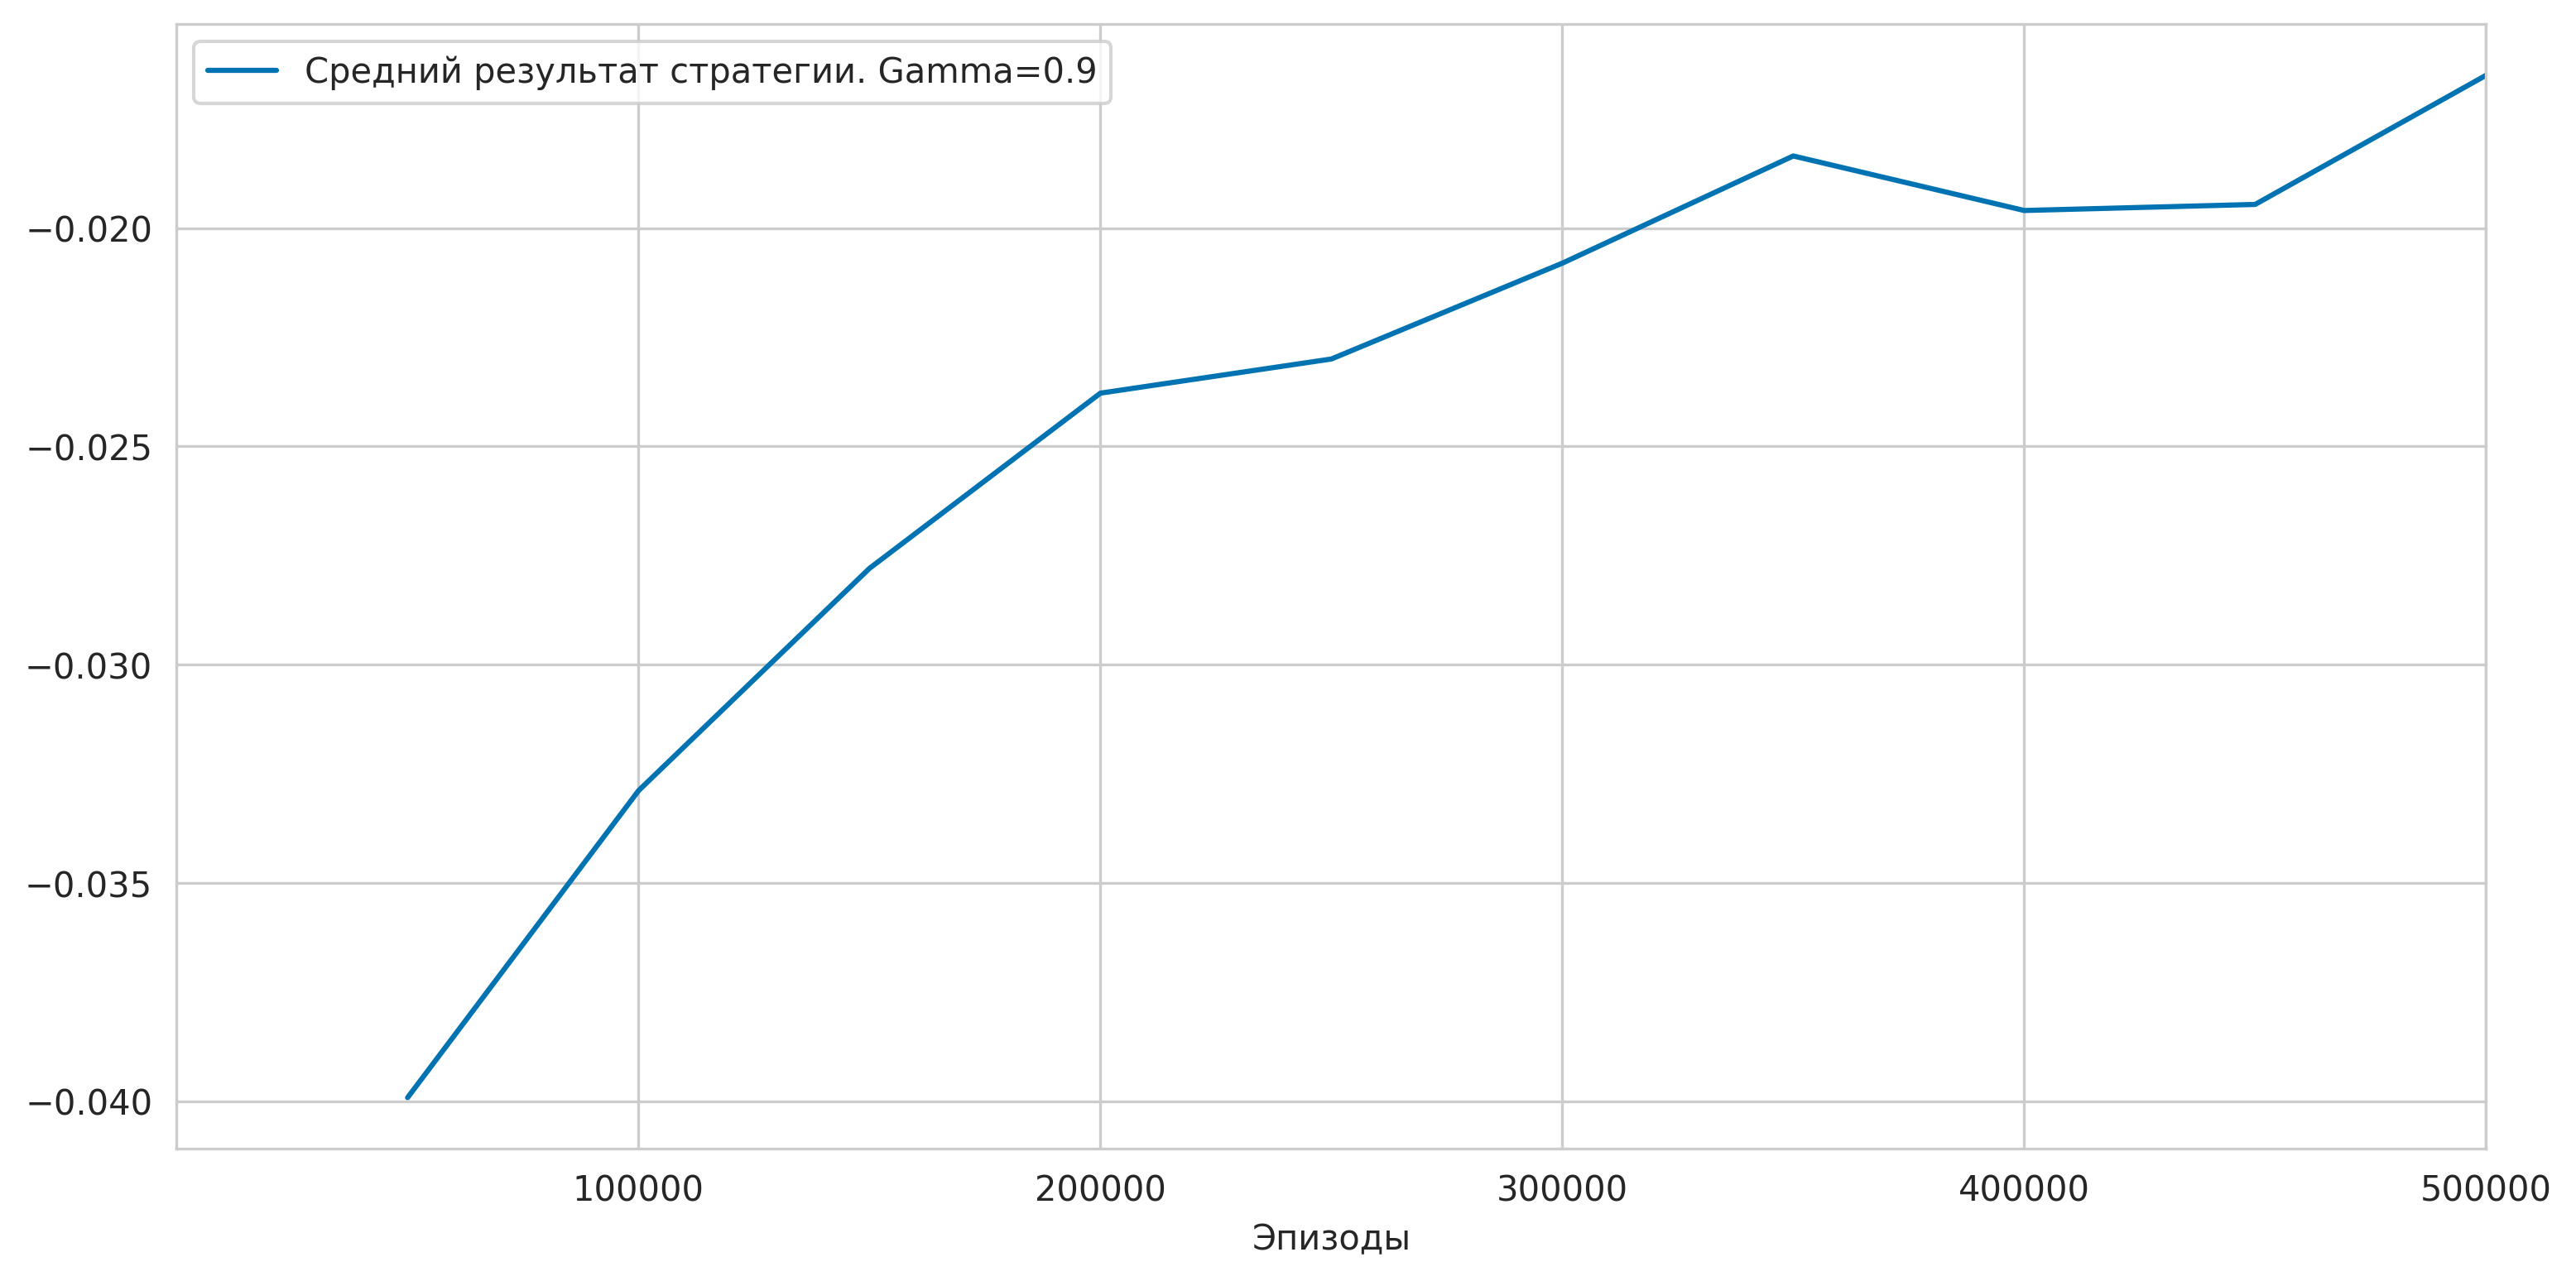

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

lines = []
labels = []
for i in range(len(gammas)):
    if i == 0:
        ax2 = ax
    else:
        ax2 = ax.twinx()
        ax2.grid(None)
    x, y = [res[0] for res in test_results2[i]], [res[1] for res in test_results2[i]]
    line = ax2.plot(x, y, label=f"Средний результат стратегии. Gamma={gammas[i]}", color=f"C{i}")
    lines += line
    labels += [l.get_label() for l in line]
ax.legend(lines, labels, loc=0)
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды");

Результат заметно улучшился, но все равно недостаточно, чтобы быть в плюсе.

## Часть третья, в главной роли — Дастин Хоффман

В blackjack_v3 реализована версия игры с подсчетом. Был использован метод "Плюс-минус" при одной колоде (подробнее можно узнать по данной [ссылке](https://www.durbetsel.ru/2_blackjack_tehnika_igry.htm)). Диапазон реального счета был ограничен значениями -10 и 10, чтобы уменьшить кол-во состояний. Итого, кол-во состояний возросло в 21 раз (для каждого целого значения из диапазона [-10, 10]).

In [5]:
from blackjack_v3 import BlackjackEnv3

In [6]:
# кол-во состояний увеличилось
n_hands, n_dealer_cards, n_usable_ace, n_counts = 32, 11, 2, 21
nS, nA = n_hands * n_dealer_cards * n_usable_ace * n_counts, 3
final_states = np.where([hand > 20 for hand in range(n_hands) 
                         for dealer in range(n_dealer_cards) 
                         for ace in range(n_usable_ace) for count in range(n_counts)])[0]

def get_state(hand, dealer, usable_ace, count):
    return hand * n_dealer_cards * n_usable_ace * n_counts \
        + dealer * n_usable_ace * n_counts + int(usable_ace) * n_counts + count

def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    Q[:, 0] = 0.0
    Q[:, 2] = 0.0
    return Q

In [7]:
env = BlackjackEnv3(natural=True)
init_episodes, total_episodes = 10000, 1000000
num_experiments_pi = 500000
step_experiments_pi = total_episodes // 10
gammas = [0.9]
test_results3 = [[] for _ in gammas]

for j, gamma in enumerate(gammas):
    print(f"Gamma={gamma}", flush=True)
    R = [ [ (0, 0) for _ in range(nA) ] for _ in range(nS) ]

    Q = get_random_Q(env)
    pi = compute_policy_by_Q(env, Q)

    for _ in tqdm.tqdm(range(init_episodes)):
        states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)

    for i in tqdm.tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
        R = update_returns_actions(R, states, actions, rewards, gamma=gamma)
        Q = get_Q_by_R(R, Q_default=Q)
        pi = compute_policy_by_Q(env, Q)
        if (i+1) % step_experiments_pi == 0 or i == total_episodes - 1:
            reward = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
            test_results3[j].append((i, reward))
        
env.close()

Gamma=0.9


100%|██████████| 1000000/1000000 [3:47:50<00:00, 73.15it/s]  


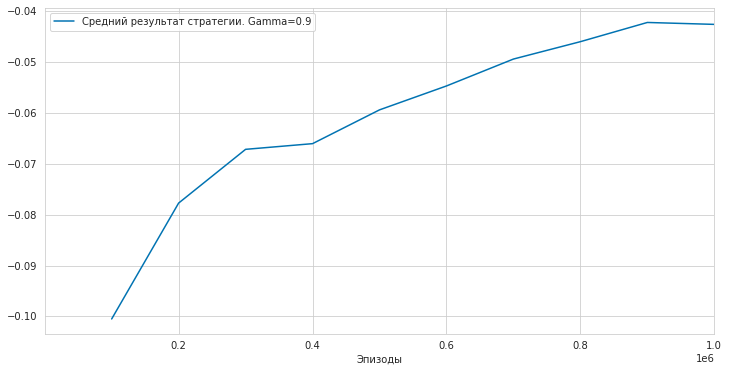

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

lines = []
labels = []
for i in range(len(gammas)):
    if i == 0:
        ax2 = ax
    else:
        ax2 = ax.twinx()
        ax2.grid(None)
    x, y = [res[0] for res in test_results3[i]], [res[1] for res in test_results3[i]]
    line = ax2.plot(x, y, label=f"Средний результат стратегии. Gamma={gammas[i]}", color=f"C{i}")
    lines += line
    labels += [l.get_label() for l in line]
ax.legend(lines, labels, loc=0)
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды");

К сожалению, это не помогло, чтобы выйти в плюс. Более того, средний результат ухудшился при неизменном значении gamma=0.9. Возможно, из-за роста кол-ва состояний в несколько раз стало необходимо проводить намного больше экспериментов. Однако, может быть и такое, что я мог где-то ошибиться.